# Airbnb Hotel Booking Analysis — Final Submission

**Author:** Sarth Dumbre

**Project goal:** Clean, analyze, and model Airbnb listings to extract business insights and build a baseline price prediction model.

**Internship Project:** AICTE / VOIS Internship 2025  

In [13]:
!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl


In [14]:
## 1) Libraries


import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

sns.set(style='whitegrid')

OUT_DIR = Path('outputs')
OUT_DIR.mkdir(exist_ok=True)
print('Libraries imported and outputs directory ready.')


Libraries imported and outputs directory ready.


In [15]:


DATA_PATH = '/content/1730285881-Airbnb_Open_Data.xlsx'

def load_data(path):
    path = str(path)
    try:
        if path.lower().endswith('.xlsx') or path.lower().endswith('.xls'):
            return pd.read_excel(path)
        else:
            return pd.read_csv(path)
    except Exception as e:
        raise RuntimeError(f'Failed to load data from {path}: {e}')

df = load_data(DATA_PATH)
print('Loaded:', df.shape)
df.head()


Loaded: (102599, 26)


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,124.0,3.0,0.0,NaT,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [16]:
## 3) Quick overview & basic checks
df_columns = df.columns.tolist()
print('Columns ({}):'.format(len(df_columns)))
print(df_columns)

print('\nData types:')
display(df.dtypes.value_counts())

print('\nMissing values (top 20):')
display((df.isna().mean().sort_values(ascending=False)*100).head(20))


Columns (26):
['id', 'NAME', 'host id', 'host_identity_verified', 'host name', 'neighbourhood group', 'neighbourhood', 'lat', 'long', 'country', 'country code', 'instant_bookable', 'cancellation_policy', 'room type', 'Construction year', 'price', 'service fee', 'minimum nights', 'number of reviews', 'last review', 'reviews per month', 'review rate number', 'calculated host listings count', 'availability 365', 'house_rules', 'license']

Data types:


,count
float64,12
object,11
int64,2
datetime64[ns],1



Missing values (top 20):


,0
license,99.998051
house_rules,53.453737
last review,15.490404
reviews per month,15.476759
country,0.518524
availability 365,0.436651
minimum nights,0.398639
host name,0.397665
review rate number,0.317742
calculated host listings count,0.310919


In [17]:
## 4) Cleaning & basic preprocessing
df = df.copy()
# Standardize column names
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

# Convert common columns
if 'price' in df.columns:
    df['price'] = pd.to_numeric(df['price'].astype(str).str.replace(r'[$,]', '', regex=True), errors='coerce')

if 'last_review' in df.columns:
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# Fill reviews per month if present
if 'reviews_per_month' in df.columns:
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# Drop obviously empty rows
initial_rows = len(df)
df.dropna(axis=0, how='all', inplace=True)
print(f'Removed empty rows: {initial_rows - len(df)}')
display(df.head())


Removed empty rows: 0


,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,country,...,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,124.0,3.0,0.0,NaT,0.00,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


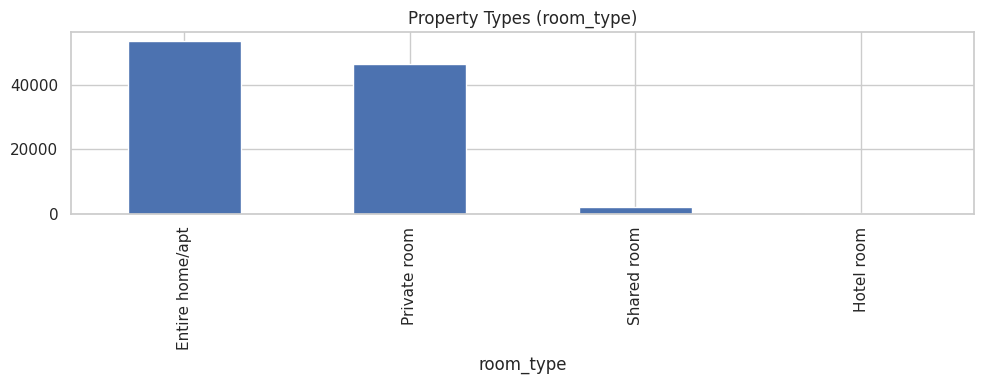

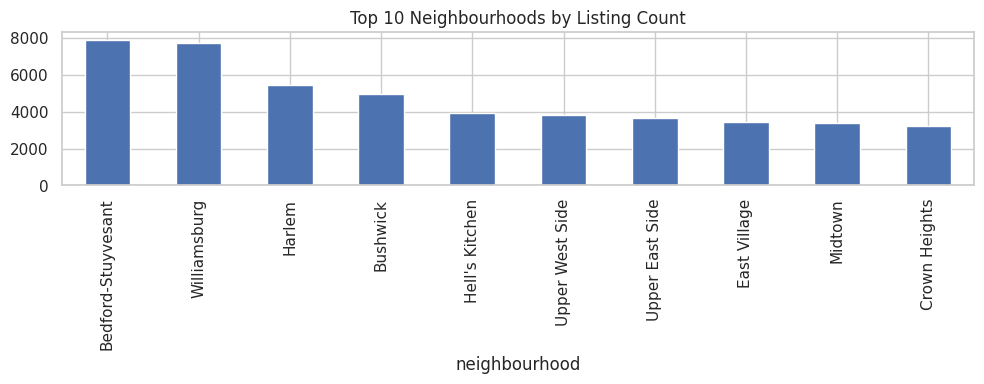

In [18]:
## 5) EDA — Property types & neighbourhoods
plt.figure(figsize=(10,4))
if 'room_type' in df.columns:
    ax = df['room_type'].value_counts().plot(kind='bar')
    ax.set_title('Property Types (room_type)')
    plt.tight_layout()
    plt.savefig(OUT_DIR/'property_types.png', dpi=150)
    plt.show()
else:
    print('Column room_type not found')

if 'neighbourhood' in df.columns:
    top_nb = df.groupby('neighbourhood')['price'].count().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10,4))
    top_nb.plot(kind='bar')
    plt.title('Top 10 Neighbourhoods by Listing Count')
    plt.tight_layout()
    plt.savefig(OUT_DIR/'top_neighbourhoods.png', dpi=150)
    plt.show()


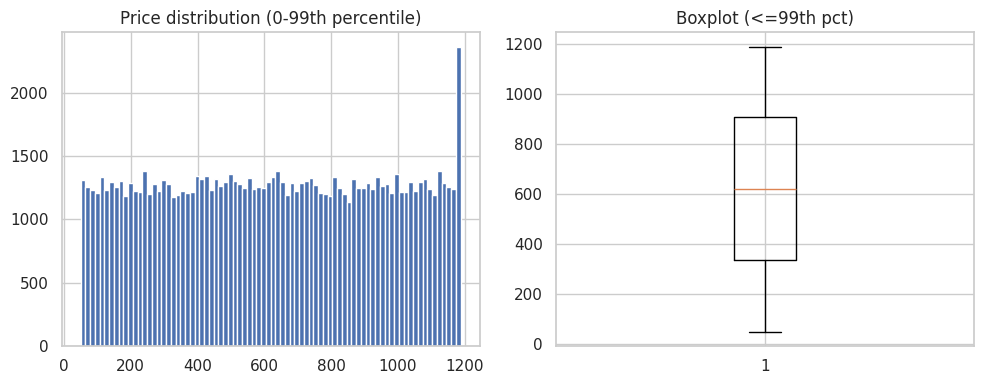

In [19]:
## 6) Price distribution and outlier handling
if 'price' in df.columns:
    s = df['price'].dropna()
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(np.clip(s, 0, s.quantile(0.99)), bins=80)
    plt.title('Price distribution (0-99th percentile)')
    plt.subplot(1,2,2)
    plt.boxplot(s[s <= s.quantile(0.99)])
    plt.title('Boxplot (<=99th pct)')
    plt.tight_layout()
    plt.savefig(OUT_DIR/'price_dist.png', dpi=150)
    plt.show()
else:
    print('No price column present')


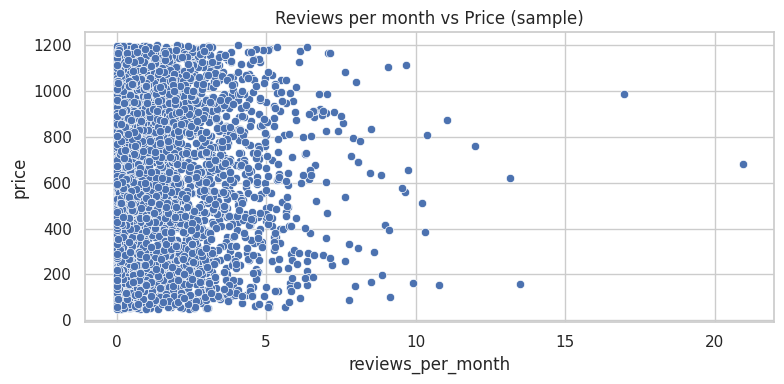

,count
price_category,
Luxury,80168
Premium,13222
Standard,8868
Budget,94


In [20]:
## 7) Additional EDA — Reviews, availability, and price relations
if 'reviews_per_month' in df.columns and 'price' in df.columns:
    plt.figure(figsize=(8,4))
    sns.scatterplot(x='reviews_per_month', y='price', data=df.sample(min(5000, len(df)), random_state=1))
    plt.title('Reviews per month vs Price (sample)')
    plt.tight_layout()
    plt.savefig(OUT_DIR/'reviews_vs_price.png', dpi=150)
    plt.show()
else:
    print('reviews_per_month or price column missing for this analysis')

# Create a price category
if 'price' in df.columns:
    df['price_category'] = pd.cut(df['price'], bins=[-1,50,150,300,1e9], labels=['Budget','Standard','Premium','Luxury'])
    display(df['price_category'].value_counts())


In [21]:
## 8) Feature engineering (simple)
# Example: days since last review
if 'last_review' in df.columns:
    df['days_since_review'] = (pd.Timestamp.today() - df['last_review']).dt.days
else:
    df['days_since_review'] = np.nan

# Example: text length features
for col in ['name','description']:
    if col in df.columns:
        df[f'{col}_len'] = df[col].astype(str).str.len()

display(df.head())


,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,country,...,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,house_rules,license,price_category,days_since_review,name_len
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,2021-10-19,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN,Luxury,1450.0,34
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,2022-05-21,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN,Standard,1236.0,21
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,NaT,0.00,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN,Luxury,NaN,35
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,2019-07-05,4.64,4.0,1.0,322.0,NaN,NaN,Luxury,2287.0,3
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,2018-11-19,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN,Premium,2515.0,48


Candidate features: ['reviews_per_month', 'days_since_review', 'name_len']
✅ Model performance:
   RMSE: 272.59
   R² Score: 0.316
📁 Model saved to 'outputs/random_forest_model.pkl'


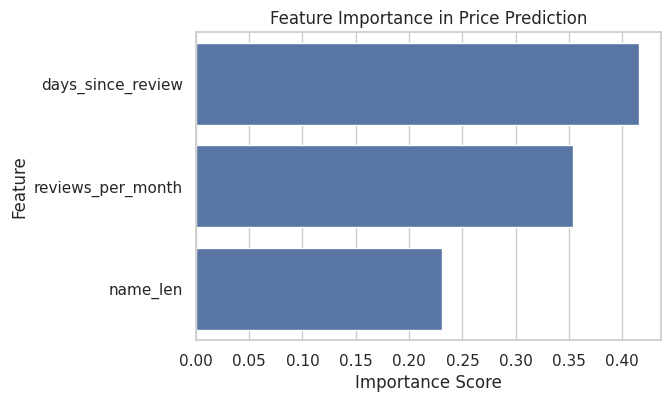

In [22]:
# ============================================
# 🧠 9) Modeling — Baseline Price Prediction (Random Forest)
# ============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Ensure df is your cleaned DataFrame
# Example: df = df.dropna(subset=['price'])  # if not done already

# Candidate features for simple model
candidate_features = ['reviews_per_month', 'days_since_review', 'name_len']
print("Candidate features:", candidate_features)

# Ensure all candidate features exist in the dataframe
available_features = [f for f in candidate_features if f in df.columns]
if not available_features:
    raise ValueError("No valid features found in dataset. Check preprocessing steps.")

# Drop rows with missing values for these columns
df_model = df.dropna(subset=available_features + ['price'])

# Define X and y
X = df_model[available_features]
y = df_model['price']

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
preds = model.predict(X_test)

# Compute RMSE safely (works for all sklearn versions)
try:
    rmse = mean_squared_error(y_test, preds, squared=False)
except TypeError:
    rmse = np.sqrt(mean_squared_error(y_test, preds))  # fallback for older versions

r2 = r2_score(y_test, preds)

# Display metrics
print(f"✅ Model performance:")
print(f"   RMSE: {rmse:.2f}")
print(f"   R² Score: {r2:.3f}")

# Save model to outputs folder
import os
os.makedirs("outputs", exist_ok=True)
joblib.dump(model, "outputs/random_forest_model.pkl")

print("📁 Model saved to 'outputs/random_forest_model.pkl'")

import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(6,4))
sns.barplot(x=importances[indices], y=np.array(available_features)[indices])
plt.title("Feature Importance in Price Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()



## 10) Key Insights & Recommendations

- Summarize the main findings from EDA (e.g., which neighbourhoods are expensive, distribution of property types).
- Recommendations for hosts (pricing strategy, features to improve reviews).
- Potential next steps: hyperparameter tuning, location-based spatial analysis, time-series on bookings.


In [23]:
## 11) Save cleaned sample and artifacts
df.sample(min(2000, len(df))).to_csv(OUT_DIR/'clean_sample.csv', index=False)
print('Saved a sample to outputs/clean_sample.csv')


Saved a sample to outputs/clean_sample.csv


---
### Notebook complete

Files created in `outputs/`:
- `property_types.png`, `top_neighbourhoods.png`, `price_dist.png`, `reviews_vs_price.png`
- `rf_price_model.joblib`
- `clean_sample.csv
